# Module 2, Lab 2, "Clustering"

# Recap

This is the second of four labs for Lesson 2 - Classical Image Segmention in Dev290x.  You should complete the tasks in this lab as part of the Clustering section of the lesson.

Please remember the lab must be completed before taking the quiz at the end of this lesson.

# Introduction

In this lab we introduce our second image segmentation project where we will use cluster operations to segment a relatively simple image. We will work through this project using the types of image processing techniques such projects typically need and then segment an image using K-means clustering.

At the end of the lab we'll review the work we've done and assess what types of images and projects this approach is effective for.


# Goals

In this tutorial, we will explore k-means clustering and how it can be applied to image segmentation. In particular, we will do the following. 

* Implement our own k-means algorithm from first principals
* Train and run OpenCV's more efficient k-means implementation


# Background

Image segmentation is the process of partitioning a digital image into multiple segments to make the image easier to analyze.  Often we are looking to locate objects and boundaries in the original image.  

A more precise way of looking at it is to say that image segmentation's goal is to assign a label to every pixel in an image such that pixels with the same label share certain characteristics.  

For example, these images show a typical road scene on the left and a segmented version of the image on the right where the cars have been separated from the road, the buildings, the people in the scene, etc.

<p float="center">
  <img src="../Images/bg-road.png" width="450" />
</p>


# _K_-means Clustering

The term '_k_-means' dates from 1967 but the standard algorithm is generally credited to Stuart Lloyd in 1957. _k_-means clustering aims to partition _n_ observations into _k_ clusters such that each observation is in the cluster with the nearest mean to it.

In general, the problem is computationally difficult (NP-hard).  However, heuristic algorithms are normally employed and these converge quickly.

The most common algorithm uses an iterative refinement technique.  Due to its ubiquity it is often just called the
_k_-means algorithm.

For image processing, to split a set of pixels into 2 sets.

Arbitrarily pick any one pixel from the image and make that the center of cluster one.
Then pick any other pixel from the image and make that the center of cluster two.

The algorithm proceeds by alternating between the following two steps:

1. *Assignment Step:* Assign each pixel to the 'closest' cluster.  Proximity is normally calculated using Euclidean distance.
2. *Update the means of the clusters:* Calculate the new means of the pixels in the new clusters.
    
3. Repeat steps 1 and 2 until the assignments no longer change or for a fixed number of iterations.

 Note: The algorithm may fail to find the optimum solution and the result may depend on the two pixels randomly chosen at the start.

Let's apply this technique to our starfish image.

First, we'll implement the algorithm ourselves initially in order to gain a deeper understanding of the technique.
Then we'll use OpenCV's K-means implementation as its faster.

First of all, we have to load our libraries:

In [1]:
# First import OpenCV, NumPY and MatPlotLib as we will use these libraries
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import * 
%matplotlib inline


Now that we have loaded the libraries we need, let's open an image, convert it to features, and store two copies of those features - one set is for our own implementation of K-means and the second set is for OpenCV's K-means.

In [2]:
# Let's use starfish.  I've picked up a blurred version of our starfish
# to make it a little easier for K-means to segment into two clusters.

img = Image.open("../Images/starfish_blur.png")

# Store the image's width and height for later use. 
imgWidth = img.size[0]
imgHeight = img.size[1]

# We're going to use 7 features to segment
# This is an experimental choice.
# Choosing and normalising features can be a matter of experimentation.

numFeatures = 7
# Create a data vector, with 7 values
#  blue
#  green
#  red
#  x
#  y
#  red - blue and
#  red - green 
#
# for every pixel in the image

# Initially I used 5 features, but when I added red-blue and red-green
# the clustering improved.

Z = np.ndarray(shape=(imgWidth * imgHeight, numFeatures), dtype = float)

# You must use float32 here as 'float' does not 
# have to be 32-bit. float32 has to be 32-bit
# and we'll shortly use a routine that needs float32s.
Z = np.float32(Z)

# Load data vector with the 7 values
for y in tqdm(range(0, imgHeight), ascii=True):
    for x in range(0, imgWidth):
        xy = (x, y)
        rgb = img.getpixel(xy)
        Z[x + y * imgWidth, 0] = rgb[0]           # blue
        Z[x + y * imgWidth, 1] = rgb[1]           # green
        Z[x + y * imgWidth, 2] = rgb[2]           # red
        # Experimentally, reduce the influence of the x,y components by dividing them by 10
        Z[x + y * imgWidth, 3] = x / 10           # x
        Z[x + y * imgWidth, 4] = y / 10           # y 
        Z[x + y * imgWidth, 5] = rgb[2] - rgb[0]  # red - blue
        Z[x + y * imgWidth, 6] = rgb[2] - rgb[1]  # red - green

# We need a second copy of our initial vector
# for OpenCV's K-means implementation.
Z2 = Z.copy()


100%|##########| 960/960 [00:06<00:00, 157.76it/s]


At this point, we've effectively assembled 'Z' which contains 7 columns (blue, red, green, an x position divided by 10, a y position divided by 10, a term representing red-blue and a term representing red-green) and contains a row for each pixel in the image. 



Now, lets turn our attention to another key data structure that we'll use --> clusterCentres.

We'll need to create an array of clusterCenters.  In our example, 'K' = 2, i.e. we're separating into two clusters.  So, we'll need two clusterCentres.  Each cluster center must contain information about each of our features.

We have 7 features, so we end up with a structure containing 2 vectors, each vector containing 7 elements.


In [3]:
# For this example, we are going to divide into two clusters.
# So, k = 2
K = 2

# Create our cluster centers.

# clusterCenter is an arrangement of 'K' vectors
# each vector 'contains' our 7 columns or features that we described 
# in the preceding code block.
# For example, eventually, clusterCenters[0][0] will contain
# the mean of the 'blue's in cluster 0 and clusterCenters[0][1] will
# contain the mean of the 'red's in cluster 0, etc.
clusterCenters = np.ndarray(shape=(K,numFeatures))

# Initialise each element of both of our vectors 
# to rand values (each random number being between the max'es & mins of that feature in Z)
maxVals = np.amax(Z)
minVals = np.amin(Z)
for i, _ in enumerate(clusterCenters):
        clusterCenters[i] = np.random.uniform(minVals, maxVals, numFeatures)

# So now we have created our cluster Centers and initialized each clusterCenter's vector

Now we must create a data vector which has one entry for every pixel in the original image.
We make this data vector contain integers as we plan to use it to remember what cluster
each pixel in the image belongs to (either 0 or 1).

In [4]:
# Let's create a data vector with an integer to represent whatever cluster a pixel belongs to. 
# We need one entry for each pixel - so that's a total of imgWidth * imgHeight's entries.
pixelClusterMembership = np.ndarray(shape=(imgWidth * imgHeight), dtype = int)


Now that we have created the data structures we need, we can start to implement the
algorithm.

We will iterate over the entire process 10 times - as it can be slow to run this many computations
in Python.

In each iteration, we will:
a) assign each pixel to either cluster 0 or cluster 1 (using Euclidean distance from the clusterCenters as our measure)
b) calculate the mean of the pixels in each cluster to form a new pair of clusterCenters.

This might take up to one minute to run.

In [5]:
iterations = 10

# For each iteration:
for iteration in tqdm(range(iterations), ascii=True):
    # Part 1: Set each pixel to its cluster
    
    # use numpy to efficiently subtract both cluster 
    # center's vectors from all of the vectors representing
    # the pixels in the image.
    distances = Z[:,None,:] - clusterCenters[None,:,:]
    
    # Square every element in distances
    distances_sq = distances**2
    
    # Get the sums of the squared vectors
    distance_sum = np.sum(distances_sq, axis=2)
    
    # get the square root of those sums
    distance = np.sqrt(distance_sum)

    # Pick the indexes of the elements with the smaller of 
    # the two distances for each point
    pixelClusterMembership = np.argmin(distance, axis=1)
       
    # Part 2: update each cluster's centroid
    #print('clusterCenters.shape: ', clusterCenters.shape)
    for i in range(K):
        # Create an empty list of pixels in this cluster
        pixelsInCluster = []

        # For each pixel, retrieve it's cluster membership
        for index, item in enumerate(pixelClusterMembership):
            # if it is member of the current cluster of interest
            if item == i:
                # add it's features to the list of pixels in the cluster
                pixelsInCluster.append(Z[index])

        if len(pixelsInCluster) == 0:
            pixelsInCluster.append(Z[0])

        # Now, for each cluster, simply get the mean of each of its 7 features
        pixelsInCluster = np.array(pixelsInCluster)
        clusterCenters[i] = np.mean(pixelsInCluster, axis=0)


100%|##########| 10/10 [00:27<00:00,  2.74s/it]


Now, we have run ten iterations of our algorithm, let's plot the results so far and see how well it is working.

100%|##########| 960/960 [00:04<00:00, 221.93it/s]


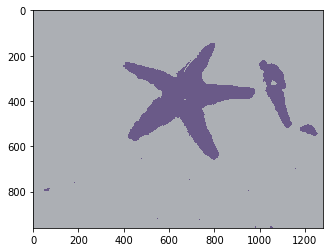

In [6]:
# Let's display an image based around what we've just done
# and convince ourselves its segmenting reasonably well (albeit slowly :-)
            
# Let's (effectively) replace every pixel in the original image
# with the rgb values from the mean of the cluster that pixel
# is now in.
outVec = np.ndarray(shape=(imgWidth * imgHeight, 3), dtype = int)
for index, item in enumerate(tqdm(pixelClusterMembership)):
    outVec[index][0] = int(round(clusterCenters[item][2]))
    outVec[index][1] = int(round(clusterCenters[item][1]))
    outVec[index][2] = int(round(clusterCenters[item][0]))

# Save and display image
img = Image.new("RGB", (imgWidth, imgHeight))

for y in tqdm(range(imgHeight), ascii=True):
    for x in range(imgWidth):
        img.putpixel((x, y), (int(outVec[y*imgWidth + x][0]), int(outVec[y * imgWidth + x][1]), int(outVec[y * imgWidth + x][2])))

#plt.figure(figsize=(14, 10), dpi=80)
plt.imshow(img)



You should be seeing an image similar to this one.

<img src="../Images/starfish-10-iterations.png" alt="Gradient Starfish" align="left" style="width: 300px;"/>


As you can see, while effective, this approach is quite slow.  Running the algorithm for only ten iterations is not enough to sufficient to achieve the type of separation we want.  This hand-made approach, while having the relatively easy to understand, suffers from performance issues.

Now that we understand how the algorithm works, we'll run OpenCV's more optimal k-means implemention so we can actually get somewhere at a reasonable pace! 

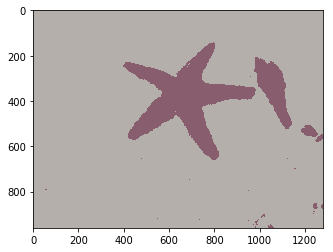

In [7]:
# OpenCV's K-means 
criteria = (cv2.TERM_CRITERIA_MAX_ITER, i+1, 0.1)
ret, label, center = cv2.kmeans(Z2,K,None,criteria,10,cv2.KMEANS_RANDOM_CENTERS)

# Convert center back into unsigned bytes
center = np.uint8(center)

# reshape the RGB values from our cv2.kmeans results into
# an image.
rgb = center[:,0:3]
res = rgb[label.flatten()]
img = res.reshape((imgHeight,imgWidth, 3))

plt.imshow(img)


You should be seeing an image a little like this one.

<img src="../Images/starfish-opencv.png" alt="Clustered Starfish" align="left" style="width: 300px;"/>



As we have seen, the OpenCV's k-means implementation performs much better than our basic implementation.  As the preceding image shows, we can use clustering techniques such as k-means when trying to segment relatively straightforward images.  

You can see some artefacts, but you can use the drawContour() technique from the first lab to extract the starfish (which is the largest image) from this image.

# Conclusions

That completes the second of the four labs to this module.

We have seen in this lab that image clustering can be successfully used for segmentation of relatively simple images. 

K-means can operate in an unsupervised manner, and has found much use in medical imagery. The selection of the features and the normalization of those features can necessitate careful selection and empirical experimentation. 

The criteria for the selection of the initial points has to be given consideration.  It is a known weakness in K-means that if we are unlucky with our initial selection of pixels to grow the clusters around, we may cluster poorly.  OpenCV's K-means gets around this by repeating the algorithm several times and choosing the best outcome.
